# Introduction

The goal of this notebook is to provide a basic implementation of the a convolutional [autoencoder](https://en.wikipedia.org/wiki/Autoencoder). The goal of this network is to compute the identity function, _i.e._ reconstruct an image as close as possible to its input. This task is not trivial as in the network, the data has to go through a bottleneck. After the training, we can split the network in two parts: the encoder and the decoder. They respectively compress and uncompress the information.  

In [1]:
%matplotlib inline
import numpy             as np
import matplotlib.pyplot as plt
import keras.backend     as K

from keras.models       import Sequential
from keras.layers       import Dense
from keras.layers       import BatchNormalization
from keras.layers       import Reshape
from keras.layers       import UpSampling2D
from keras.layers       import Convolution2D
from keras.layers       import Activation
from keras.layers       import Flatten
from keras.layers       import AveragePooling2D
from keras.optimizers   import Adam
from keras.datasets     import mnist

from tqdm import tqdm

Using TensorFlow backend.


In [2]:
def limit_mem():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

We load the MNIST data and reshape it into the 2D arrays.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n       = len(X_train)
X_train = X_train.reshape(n          , -1).astype(np.float32)
X_test  = X_test.reshape( len(X_test), -1).astype(np.float32)
X       = np.concatenate([X_train, X_test])
X       = (X - 127.5) / 127.5
X       = np.reshape(X, (-1, 28, 28, 1))

We now choose the number of dimensions of the code.

In [4]:
encoding_size = 4

The encoder is a sequence of convolutional layers and average pooling with a fully connected layer to produce the final code.

In [5]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (28, 28, 1)),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(encoding_size),
    Activation('tanh')
])

The decoder first applies a fully connected layer to reshape the input into a shape that 'divide' the final picture size (7, 7, 1). After that, a sequence of upsamplings and convolutions is applied to reach the correct size.

In [6]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,)),
    BatchNormalization(),
    Activation('relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(128, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    Convolution2D(64, (3, 3), padding = 'same'),
    BatchNormalization(axis = 1),
    Activation('relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh')
])

As explained earlier, the autoencoder is a concatenation of the encoder and the decoder.

In [7]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(), loss = 'mse')

To test the architecture, we select a sample of the dataset to train the autoencoder.

In [8]:
X_sample = np.random.permutation(X)[:10000]

In [9]:
autoencoder.fit(X_sample, X_sample, batch_size = 128, epochs = 30, verbose = 2)

Epoch 1/30
34s - loss: 0.2550
Epoch 2/30
32s - loss: 0.1928
Epoch 3/30
32s - loss: 0.1707
Epoch 4/30
32s - loss: 0.1593
Epoch 5/30
32s - loss: 0.1526
Epoch 6/30
32s - loss: 0.1464
Epoch 7/30
32s - loss: 0.1429
Epoch 8/30
32s - loss: 0.1382
Epoch 9/30
32s - loss: 0.1365
Epoch 10/30
32s - loss: 0.1338
Epoch 11/30
32s - loss: 0.1320
Epoch 12/30
32s - loss: 0.1299
Epoch 13/30
32s - loss: 0.1288
Epoch 14/30
32s - loss: 0.1285
Epoch 15/30
32s - loss: 0.1266
Epoch 16/30
32s - loss: 0.1257
Epoch 17/30
32s - loss: 0.1236
Epoch 18/30
32s - loss: 0.1228
Epoch 19/30
32s - loss: 0.1230
Epoch 20/30
32s - loss: 0.1214
Epoch 21/30
32s - loss: 0.1208
Epoch 22/30
32s - loss: 0.1194
Epoch 23/30
32s - loss: 0.1179
Epoch 24/30
32s - loss: 0.1194
Epoch 25/30
32s - loss: 0.1187
Epoch 26/30
32s - loss: 0.1176
Epoch 27/30
32s - loss: 0.1169
Epoch 28/30
32s - loss: 0.1163
Epoch 29/30
32s - loss: 0.1167
Epoch 30/30
32s - loss: 0.1159


In [20]:
autoencoder.optimizer.lr = 1e-4

In [21]:
autoencoder.fit(X_sample, X_sample, batch_size = 128, epochs = 10, verbose = 2)

Epoch 1/10
32s - loss: 0.1148
Epoch 2/10
32s - loss: 0.1150
Epoch 3/10
32s - loss: 0.1147
Epoch 4/10
32s - loss: 0.1139
Epoch 5/10
32s - loss: 0.1124
Epoch 6/10
32s - loss: 0.1128
Epoch 7/10
32s - loss: 0.1129
Epoch 8/10
32s - loss: 0.1128
Epoch 9/10
32s - loss: 0.1113
Epoch 10/10
32s - loss: 0.1125


In [28]:
autoencoder.optimizer.lr = 1e-5

In [29]:
autoencoder.fit(X_sample, X_sample, batch_size = 64, epochs = 15, verbose = 2)

Epoch 1/15
33s - loss: 0.1241
Epoch 2/15
33s - loss: 0.1234
Epoch 3/15
33s - loss: 0.1213
Epoch 4/15
33s - loss: 0.1195
Epoch 5/15
33s - loss: 0.1202
Epoch 6/15
33s - loss: 0.1193
Epoch 7/15
33s - loss: 0.1197
Epoch 8/15
33s - loss: 0.1177
Epoch 9/15
33s - loss: 0.1168
Epoch 10/15
33s - loss: 0.1178
Epoch 11/15
33s - loss: 0.1168
Epoch 12/15
33s - loss: 0.1174
Epoch 13/15
33s - loss: 0.1175
Epoch 14/15
33s - loss: 0.1164
Epoch 15/15
33s - loss: 0.1154


In [30]:
autoencoder.save_weights('../models/autoencoder_%dD.h5' % encoding_size)

In [31]:
autoencoder.load_weights('../models/autoencoder_%dD.h5' % encoding_size)

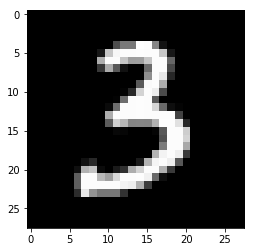

In [32]:
plt.imshow(X_sample[51].squeeze(), cmap = 'gray')

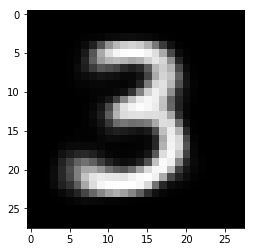

In [33]:
plt.imshow(autoencoder.predict(np.expand_dims(X_sample[51], 0)).squeeze(), cmap = 'gray')

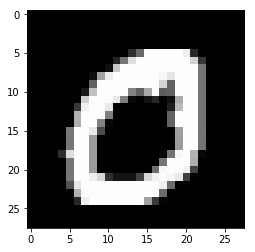

In [34]:
plt.imshow(X[51].squeeze(), cmap = 'gray')

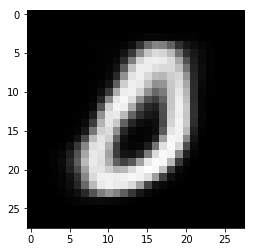

In [35]:
plt.imshow(autoencoder.predict(np.expand_dims(X[34], 0)).squeeze(), cmap = 'gray')